In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.robin.labs.entities import RobinLab

path_config_supply = '../configs/supply_data.yml'
path_config_demand = '../configs/demand_data.yml'
tmp_path = '../data/labs/tmp'

In [6]:
config = {"supply": {"start": 0.0, "stop": 30.0, "step": 1.0},
          "demand": ()}

robin_lab = RobinLab(path_config_supply=path_config_supply,
                     path_config_demand=path_config_demand,
                     tmp_path=tmp_path,
                     lab_config=config)

Generating supply data...


In [7]:
robin_lab.simulate()

Successfully simulated supply file:  supply_0.0.yml
Successfully simulated supply file:  supply_2.0.yml
Successfully simulated supply file:  supply_4.0.yml
Successfully simulated supply file:  supply_6.0.yml
Successfully simulated supply file:  supply_8.0.yml


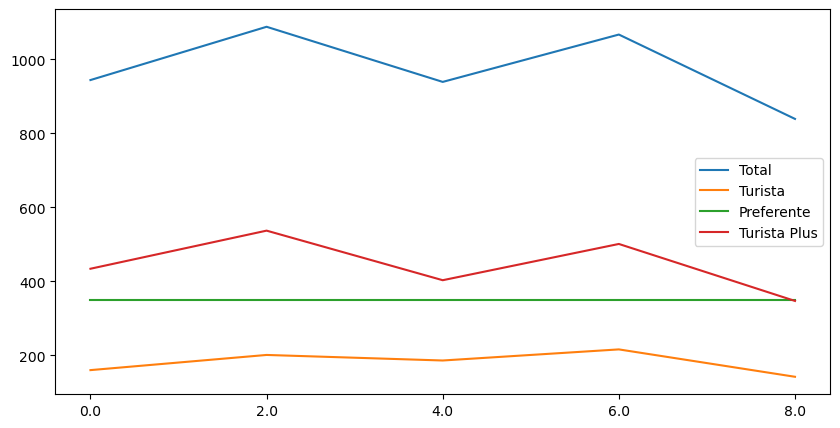

In [8]:
robin_lab.plot_elasticity_curve()

In [1]:
!pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable


In [5]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [1]:
import datetime
import ipywidgets as widgets
import pandas as pd

from ipywidgets import interact, interact_manual

In [2]:
def range_dates(start_date: datetime.datetime, end_date: datetime.datetime):
    print(f"Dates between {start_date} and {end_date}")

interact(range_dates,
         start_date=widgets.DatePicker(value=pd.to_datetime('2023-01-01')),
         end_date=widgets.DatePicker(value=pd.to_datetime('2023-06-01')))

interactive(children=(DatePicker(value=Timestamp('2023-01-01 00:00:00'), description='start_date'), DatePicker…

<function __main__.range_dates(start_date: datetime.datetime, end_date: datetime.datetime)>

In [ ]:
"""
Supply experiment configuration

- Prices
- Capacities
- Capacity constraints

Steps:
1) Load defult supply configuration
2) Select which parameters want to be analyzed through the experiment
3) Interactively select the values based on the observed data
4) Generate YAML files for the experiment
"""